## Baseline: Replicate least year

In [1]:
import os
import datetime

import numpy as np
import pandas as pd
import geopandas as gpd
import dateutil 

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import notebook_utils

In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src')

from helpers import api, data_utils

In [4]:
MODEL_NAME = 'baseline_replicate_last_year'
N_PRED_DAYS = 7
groups = ['embeddings', 'nonselected']
test_start_time = dateutil.easter.easter(2019) - datetime.timedelta(days=6)
test_end_time = test_start_time + pd.DateOffset(days = N_PRED_DAYS)
last_year_start_time = dateutil.easter.easter(2018) - datetime.timedelta(days=6)
last_year_end_time = last_year_start_time + pd.DateOffset(days = N_PRED_DAYS)

In [5]:
link_refs = {}
for group in groups:
    with open(f'../output/links_{group}.txt') as f:
        link_refs_ = f.readlines()
        link_refs[group] = list(filter(lambda x: not x.startswith('#'), [x.strip() for x in link_refs_]))

In [21]:
time_slug = test_start_time.isoformat().replace('-', '')

train = {}
test = {}
for group in groups:    
    for link_ref in link_refs[group]:        
        
        link_ref_slug = link_ref.replace(':', '-')        
        output_directory = f'../output/{MODEL_NAME}/{group}/{link_ref_slug}'
        if not os.path.exists(output_directory):
            os.makedirs(output_directory)
        train[link_ref] = api.link_travel_time(link_ref, from_time=last_year_start_time, to_time=last_year_end_time, verbose=False)
        test[link_ref] = api.link_travel_time(link_ref, from_time=test_start_time, to_time=test_end_time, verbose=False)
        
        train[link_ref]['link_travel_time_exp'] = train[link_ref].rolling(window=20, center=True, min_periods=1)['link_travel_time'].mean().round(1)
        test[link_ref]['link_travel_time_exp'] = test[link_ref].rolling(window=20, center=True, min_periods=1)['link_travel_time'].mean().round(1)
        
        # Find closets match for relative offset for test in train
        train_lookup = train[link_ref].index - pd.to_datetime(last_year_start_time)

        preds = []
        for ix, row in test[link_ref].iterrows():
            offset = ix - pd.to_datetime(test_start_time)
            closets_match = np.abs(train_lookup - offset).argmin()
            preds.append(train[link_ref].iloc[closets_match]['link_travel_time_exp'])
            
        test[link_ref][MODEL_NAME] = preds
        test[link_ref].to_csv(f"{output_directory}/test_{time_slug}.csv")

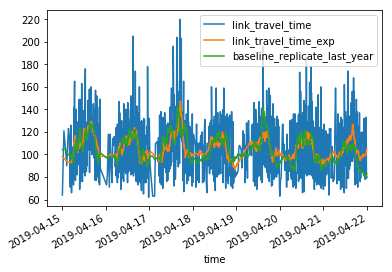

In [22]:
test[link_ref].plot()